# Citi Bike - Datenexploration und Bereinigung

In diesem Notebook werden die Citi Bike-Daten für die nachfolgenden Analysen vorbereitet.
Sie umfassen sämtliche Fahrrad- und E-Bike-Fahrten in New York City im Jahr 2023.

Der Ablauf ist zweigeteilt:

**1. Exploration der Rohdaten**

In diesem Abschnitt werden Struktur, Qualität und grundlegende Eigenschaften der Citi Bike-Daten untersucht.  
Die Exploration dient rein der Orientierung: Datentypen, Zeiträume, fehlende Werte, Ausreißer, Koordinaten und erste räumliche/zeitliche Muster werden geprüft.  
Es werden hier bewusst nur solche Transformationen durchgeführt, die erforderlich sind, um die Daten überhaupt sinnvoll beurteilen zu können.

**2. Finale Bereinigung (Single Source of Truth)**

Nach vollständiger Exploration wird ein konsistenter, vollständig bereinigter Datensatz erstellt.  
Alle Cleaning-Schritte werden hier in definierter Reihenfolge ausgeführt, unabhängig von den explorativen Zwischenschritten.  
Ziel ist ein stabiler, zuverlässiger Datensatz, der für spätere Analysen genutzt wird.

Die Trennung von Exploration und finaler Bereinigung sorgt dafür, dass die Untersuchung der Rohdaten nachvollziehbar bleibt und die Bereinigung klar reproduzierbar durchgeführt werden kann.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import sys
sys.path.append("../..")

from utils.load_data import load_citibike_raw
from utils.paths import DATA_RAW_PROCESSED
from utils.paths import FIGURES_DIR

## 1. Laden und erster Überblick über die Daten

In [2]:
# Rohdaten laden (nutzt bestehendes Parquet 
# oder erstellt es durch Zusammenführen aller CSV-Dateien)
df_cb_raw = load_citibike_raw()

# Überblick über die resultierende Tabellenform
print("Form des Datensatzes (Zeilen, Spalten):", df_cb_raw.shape)

CitiBike-Daten aus bestehender Datei geladen: citibike_raw_concat.parquet
Form des Datensatzes (Zeilen, Spalten): (35106986, 13)


In [3]:
# Erste 5 Zeilen anzeigen
df_cb_raw.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A8518A6C4BE513DE,classic_bike,2023-01-03 23:14:52.325,2023-01-03 23:33:42.737,E 1 St & Bowery,5636.13,Spruce St & Nassau St,5137.10,40.724861,-73.992131,40.711464,-74.005524,casual
1,A3911E4F5B9B5773,electric_bike,2023-01-07 07:57:40.054,2023-01-07 08:01:27.330,E 1 St & Bowery,5636.13,Ave A & E 11 St,5703.13,40.724861,-73.992131,40.728547,-73.981759,casual
2,AE7F74C32AEBF6F2,electric_bike,2023-01-09 18:37:44.830,2023-01-09 18:48:56.233,1 Ave & E 39 St,6303.01,E 14 St & 1 Ave,5779.10,40.747140,-73.971130,40.731393,-73.982867,member
3,6E10997509D2B7F6,electric_bike,2023-01-05 19:06:15.350,2023-01-05 19:08:33.547,E Burnside Ave & Ryer Ave,8397.02,E Burnside Ave & Ryer Ave,8397.02,40.850535,-73.901318,40.850535,-73.901318,casual
4,AA546E74A9330BD4,electric_bike,2023-01-02 20:25:23.300,2023-01-03 10:51:25.164,Clermont Ave & Park Ave,4692.01,Clermont Ave & Park Ave,4692.01,40.695734,-73.971297,40.695734,-73.971297,casual


In [4]:
# Übersicht über Spalten und Datentypen
df_cb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35106986 entries, 0 to 35106985
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  string 
 5   start_station_id    string 
 6   end_station_name    string 
 7   end_station_id      string 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(5), string(4)
memory usage: 3.4+ GB


---

## 2. Exploration der Daten

### 2.1 Zeitliche Eigenschaften der Fahrten

In [5]:
# Zeitstempel konvertieren und Zeitraum prüfen
df_cb_raw['started_at'] = pd.to_datetime(df_cb_raw['started_at'], errors='coerce')
df_cb_raw['ended_at']   = pd.to_datetime(df_cb_raw['ended_at'], errors='coerce')

print("Frühester Startzeitpunkt:", df_cb_raw['started_at'].min())
print("Spätester Startzeitpunkt:", df_cb_raw['started_at'].max())

print("Frühester Endzeitpunkt:", df_cb_raw['ended_at'].min())
print("Spätester Endzeitpunkt:", df_cb_raw['ended_at'].max())

Frühester Startzeitpunkt: 2022-12-14 11:43:54.762000
Spätester Startzeitpunkt: 2023-12-31 23:56:57.626000
Frühester Endzeitpunkt: 2023-01-01 00:00:07.185000
Spätester Endzeitpunkt: 2023-12-31 23:59:57.057000


### 2.2 Duplikate

In [6]:
# Duplikate der ride_id prüfen
df_cb_raw['ride_id'].duplicated().sum()

# Duplikate anzeigen
dupes = df_cb_raw[df_cb_raw['ride_id'].duplicated(keep=False)]
dupes.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


### 2.3 Fehlende Werte

In [7]:
# Prozentualer Anteil fehlender Werte pro Spalte
missing_values_pct = df_cb_raw.isna().mean().sort_values(ascending=False)

print("Prozentualer Anteil fehlender Werte pro Spalte:")
print(missing_values_pct)

Prozentualer Anteil fehlender Werte pro Spalte:
end_station_name      0.002846
end_station_id        0.002846
end_lat               0.002829
end_lng               0.002829
start_station_name    0.000518
start_station_id      0.000518
start_lat             0.000518
start_lng             0.000518
ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
member_casual         0.000000
dtype: float64


### 2.4 Fahrtdauer

In [8]:
# Fahrtdauer in Minuten berechnen
df_cb_raw['duration_min'] = (df_cb_raw['ended_at'] - df_cb_raw['started_at']).dt.total_seconds() / 60

print("Statistische Kennzahlen der Fahrtdauer (in Minuten):")
df_cb_raw['duration_min'].describe()

Statistische Kennzahlen der Fahrtdauer (in Minuten):


count    3.510699e+07
mean     1.546236e+01
std      1.077370e+02
min     -5.742862e+01
25%      5.330317e+00
50%      9.347517e+00
75%      1.652850e+01
max      1.673076e+05
Name: duration_min, dtype: float64

In [9]:
# Ausreißer bei der Fahrtdauer prüfen
print("Anzahl Fahrten mit Dauer <= 0 Minuten:", df_cb_raw[df_cb_raw['duration_min'] <= 0].shape[0])
print("Anzahl Fahrten mit Dauer > 24 Stunden:", df_cb_raw[df_cb_raw['duration_min'] > 24*60].shape[0])

Anzahl Fahrten mit Dauer <= 0 Minuten: 324
Anzahl Fahrten mit Dauer > 24 Stunden: 26640


### 2.5 Räumliche Koordinaten

In [10]:
# Plausibilität der Startkoordinaten prüfen
# Grobe räumliche Filterung: gültige CitiBike-Koordinaten liegen ungefähr im Bereich der Metropolregion New York
invalid_coords = df_cb_raw[
    (df_cb_raw['start_lat'] < 40) | (df_cb_raw['start_lat'] > 41) |
    (df_cb_raw['start_lng'] < -75) | (df_cb_raw['start_lng'] > -73)
]

print("Anzahl unplausibler Startkoordinaten:", len(invalid_coords))

Anzahl unplausibler Startkoordinaten: 0


### 2.6 Kategorien und Stationen

In [11]:
# Kategorien untersuchen: Nutzerstatus und Fahrradtyp
print("Verteilung der Nutzerkategorien:")
print(df_cb_raw['member_casual'].value_counts(dropna=False))

print("\nVerteilung der Fahrradtypen:")
print(df_cb_raw['rideable_type'].value_counts(dropna=False))

Verteilung der Nutzerkategorien:
member_casual
member    28513791
casual     6593195
Name: count, dtype: int64

Verteilung der Fahrradtypen:
rideable_type
electric_bike    17605824
classic_bike     17501162
Name: count, dtype: int64


In [12]:
# Anzahl einzigartiger Stationen bestimmen
num_start = df_cb_raw['start_station_id'].nunique()
num_end   = df_cb_raw['end_station_id'].nunique()

print("Anzahl einzigartiger Startstationen:", num_start)
print("Anzahl einzigartiger Endstationen:", num_end)

Anzahl einzigartiger Startstationen: 2347
Anzahl einzigartiger Endstationen: 2354


### 2.7 Zeitliche Übersicht

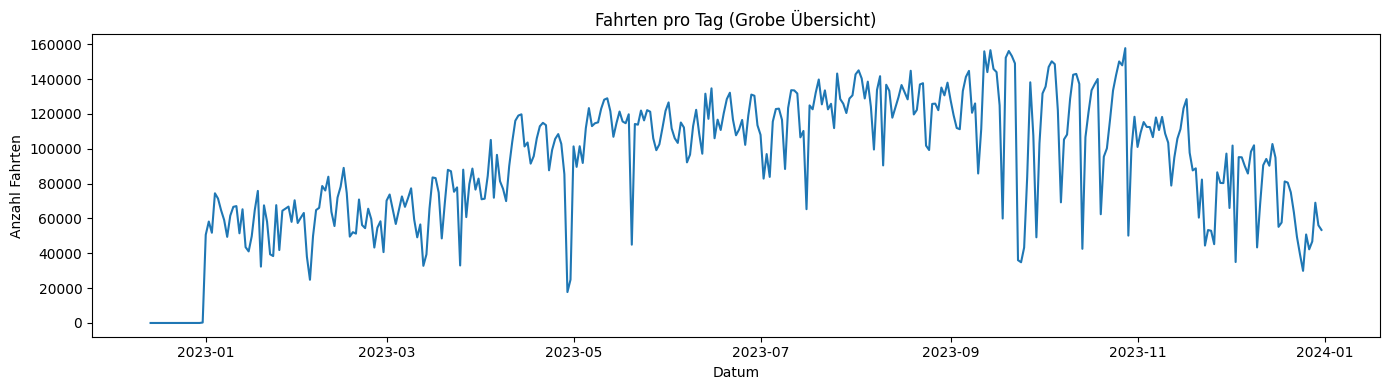

Abbildung gespeichert: trips_per_day.png


In [13]:
# Erste zeitliche Übersicht: Fahrten pro Tag
df_cb_raw['date'] = df_cb_raw['started_at'].dt.date
trips_per_day = df_cb_raw.groupby('date').size()

trips_per_day.plot(figsize=(14,4))
plt.title("Fahrten pro Tag (Grobe Übersicht)")
plt.ylabel("Anzahl Fahrten")
plt.xlabel("Datum")
plt.tight_layout()

# Speichern
save_dir = os.path.join(FIGURES_DIR, "02A_citibike_data_preparation")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "trips_per_day.png")
plt.savefig(save_path, dpi=300)

plt.show()
print("Abbildung gespeichert:", os.path.basename(save_path))


### 2.8 Räumliche Übersicht

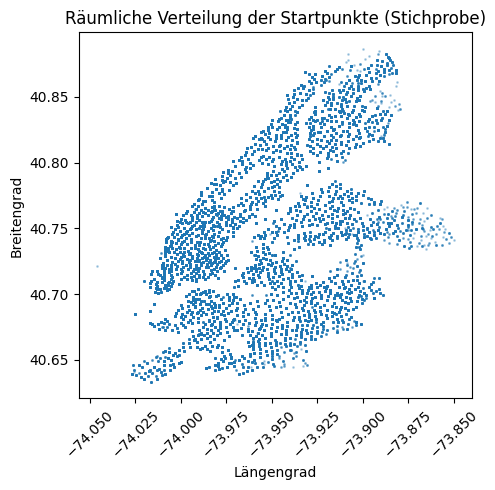

Abbildung gespeichert: spatial_distribution_startpoints.png


In [14]:
# Erste räumliche Übersicht: zufälliges Sample der Startpunkte visualisieren
sample = df_cb_raw.sample(200_000)

plt.figure(figsize=(5,5))
plt.scatter(sample['start_lng'], sample['start_lat'], s=1, alpha=0.3)

plt.title("Räumliche Verteilung der Startpunkte (Stichprobe)")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")

plt.xticks(rotation=45)
plt.tight_layout()

# Speichern
save_dir = os.path.join(FIGURES_DIR, "02A_citibike_data_preparation")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "spatial_distribution_startpoints.png")
plt.savefig(save_path, dpi=300)

plt.show()
print("Abbildung gespeichert:", os.path.basename(save_path))

### 2.9 Qualitätsreport

In [15]:
# Qualitätsreport über zentrale Datenqualitätsindikatoren
quality_report = {
    "anzahl_zeilen": len(df_cb_raw),
    "fehlende_start_koordinaten_prozent": float(df_cb_raw['start_lat'].isna().mean()),
    "fehlende_end_koordinaten_prozent": float(df_cb_raw['end_lat'].isna().mean()),
    "anzahl_fahrten_dauer_leq_0": int(len(df_cb_raw[df_cb_raw['duration_min'] <= 0])),
    "anzahl_fahrten_dauer_gt_24h": int(len(df_cb_raw[df_cb_raw['duration_min'] > 1440])),
    "anzahl_startstationen": int(df_cb_raw['start_station_id'].nunique()),
    "anzahl_endstationen": int(df_cb_raw['end_station_id'].nunique())
}

print("Qualitätsreport:")
quality_report


Qualitätsreport:


{'anzahl_zeilen': 35106986,
 'fehlende_start_koordinaten_prozent': 0.0005183583689012779,
 'fehlende_end_koordinaten_prozent': 0.0028286677756956978,
 'anzahl_fahrten_dauer_leq_0': 324,
 'anzahl_fahrten_dauer_gt_24h': 26640,
 'anzahl_startstationen': 2347,
 'anzahl_endstationen': 2354}

---

## 3. Bereinigung und Aufbereitung des Datensatzes

Dieser Abschnitt erstellt den finalen, konsistent bereinigten Datensatz, der als Grundlage für alle folgenden Analysen dient.  
Die explorative Untersuchung zuvor diente ausschließlich der Orientierung.  
Für die finale Aufbereitung werden alle Bereinigungsschritte daher nochmals in definierter Reihenfolge ausgeführt, unabhängig von den explorativen Zwischenschritten.  
So entsteht eine klar reproduzierbare „Single Source of Truth“.

### 3.1 Zeitliche und logische Konsistenz
Die Daten werden auf das Jahr 2023 eingeschränkt, um sie zeitlich mit den NYPD-Unfalldaten abzugleichen.  
Anschließend werden unplausible Fahrten entfernt – darunter Fahrten mit negativen oder extrem langen Dauerwerten (> 24h) sowie Einträge, bei denen der Endzeitpunkt vor dem Startzeitpunkt liegt.  
Insgesamt betrifft dies **26.964 Fahrten**, was nur etwa **0,077 %** der ursprünglich **35,1 Mio. Zeilen** entspricht.  
Das Entfernen dieser fehlerhaften Einträge führt daher zu keiner relevanten Verzerrung.

### 3.2 Vollständigkeit der Daten
Die Missing-Value-Analyse zeigt, dass nahezu alle strukturellen Attribute vollständig vorliegen.  
Lediglich die Koordinatenspalten weisen geringe Missing-Anteile auf (**< 0.003 %**)
Da vollständige Koordinaten für räumliche Analysen zwingend erforderlich sind und die betroffenen Zeilen nur einen sehr kleinen Bruchteil darstellen, werden sie vollständig entfernt.  

### 3.3 Speicher- und Strukturoptimierung
Zur Reduktion des Speicherverbrauchs werden folgende Schritte vorgenommen:  
Diskrete Merkmale wie Station-IDs, Fahrradtyp und Nutzerstatus werden als `category` gespeichert.  
Zusätzlich werden nicht benötigte Attribute wie Stationsnamen entfernt.  
Ein Vorher-Nachher-Vergleich des Speicherverbrauchs zeigt die Wirkung dieser Optimierungen.

Der bereinigte Datensatz wird anschließend gespeichert und bildet ab diesem Punkt die verbindliche Grundlage für alle räumlichen, zeitlichen und segmentbezogenen Analysen.

In [16]:
# Speicherverbrauch des Rohdatensatzes (vor dem Cleaning)
initial_memory_mb = df_cb_raw.memory_usage(deep=True).sum() / (1024*1024)
print("Speicherverbrauch vor der Bereinigung (MB):", initial_memory_mb)

# Kopie des Rohdatensatzes
df_cb = df_cb_raw.copy()

# Datetime-Konvertierung
df_cb['started_at'] = pd.to_datetime(df_cb['started_at'], errors='coerce')
df_cb['ended_at']   = pd.to_datetime(df_cb['ended_at'], errors='coerce')

# Filterung auf das Jahr 2023
df_cb = df_cb[df_cb['started_at'].dt.year == 2023]

# Fahrtdauer berechnen
df_cb['duration_min'] = (
    df_cb['ended_at'] - df_cb['started_at']
).dt.total_seconds() / 60

# Entfernen unplausibler Fahrten
df_cb = df_cb[df_cb['ended_at'] >= df_cb['started_at']]
df_cb = df_cb[df_cb['duration_min'] > 0]
df_cb = df_cb[df_cb['duration_min'] < 1440]  # <24h

# Entfernen fehlender Koordinaten
df_cb = df_cb.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])

df_cb['ride_id'] = df_cb['ride_id'].astype('category')
df_cb['rideable_type'] = df_cb['rideable_type'].astype('category')
df_cb['member_casual'] = df_cb['member_casual'].astype('category')

# Entfernen unnötiger Spalten
df_cb = df_cb.drop(columns=[
    'ride_id',
    'start_station_name',
    'end_station_name',
    'start_station_id',
    'end_station_id'
])

# Anzahl verbleibender Zeilen
print("Anzahl verbleibender Zeilen:", len(df_cb))

# Anteil der behaltenen Zeilen bezogen auf den Ausgangsdatensatz
print("Anteil der behaltenen Zeilen:", round(len(df_cb) / len(df_cb_raw), 6))

# Speicherverbrauch nach dem Cleaning
final_memory_mb = df_cb.memory_usage(deep=True).sum() / (1024*1024)
reduction_ratio = (initial_memory_mb - final_memory_mb) / initial_memory_mb
print(f"Speicherverbrauch nach der Bereinigung (MB): {final_memory_mb:.2f}")
print(f"Eingesparte Speichermenge (MB): {initial_memory_mb - final_memory_mb:.2f}")
print("Reduktion:", f"{reduction_ratio*100:.2f}%")

# Speichern
path = os.path.join(DATA_RAW_PROCESSED, "citibike_clean.parquet")
df_cb.to_parquet(path, index=False)
print("Bereinigter Datensatz gespeichert:", os.path.basename(path))

Speicherverbrauch vor der Bereinigung (MB): 17660.292581558228
Anzahl verbleibender Zeilen: 35000377
Anteil der behaltenen Zeilen: 0.996963
Speicherverbrauch nach der Bereinigung (MB): 3538.17
Eingesparte Speichermenge (MB): 14122.12
Reduktion: 79.97%
Bereinigter Datensatz gespeichert: citibike_clean.parquet
